#### Ahora mismo:
- Modularizar GradCAM
- Implementación de GradCAM++
- Tratamiento de BBDD
    - Coger las imágenes y dividirlas en 4 (con solapamiento que sea). En principio se van a hacer con las pares y las impares pero guardándolas en directorios distintos por si acaso luego tenemos que recurrir a las impares. Al hacer el parche tanto de la imagen como de su máscara, comprobamos el porcentaje de información que tiene la máscara. Si no tiene, la desechamos.
- Índice de la memoria + parte teórica

#### Pasos siguientes:
- Implementación de SmoothGradCAM++
- Entrenamiento de los clasificadores en BBDD-tratado
- Explicación con CAM, GradCAM, GradCAM++ y SmoothGradCAM++ con los modelos entrenados
- Análisis de resultados

#### Hecho:
- Modularizar CAM
- Implementación CAM y gradCAM
- Selección de clasificadores (torch.models) (VGG, ResNet, Inception, MobileNet)

#### Dudas para siguiente sesión:
- Las capas totalmente conectadas no las he podido ir reduciendo en potencias de 2 porque excedía la memoria de la GPU.
- GradCAM lleva una capa ReLU para dar el saliency map. ¿Es buena idea ponérselo también a CAM?
- Paper de GradCAM++. En la computación de derivadas. Dice de coger la penúltima capa S^c y pone el supuesto caso de que la última capa sea lineal o relu. 
    - **QUÉ ENTIENDO YO**: si cogiésemos la penúltima capa, no se podría coger respecto de la clase c, porque eso solo lo tiene la última capa (tiene tantas salidas como números de clases) y al ser fully connected no tiene sentido. Por lo tanto, creo que se refiere a que cojamos nuestra última capa S^c, le pasemos una exponencial y luego una relu.
    - **PROBLEMA**: al hacer las derivadas, da por supuesto que la relu() va antes de la exponencial cuando al principio dice que pasamos la exponencial a los valores de la penúltima capa S^c. Si la última capa fuera relu no tendría sentido alguno porque la exponencial es siempre positiva entonces quedaría invariante. 
    - **QUÉ CREO QUE HACE**: creo que a la salida original le pasa una ReLU, y a eso ya le aplica una exponencial/softmax.
    - **CONCLUSIÓN SACADA**: al modelo con las nuevas FC le metemos al final una relu antes del softmax y podemos usar eso.

In [658]:
from torch.nn.modules.pooling import AdaptiveAvgPool2d
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor, Lambda
import torchvision.models as models
import torchvision

import torch.optim as optim
from torch.optim import lr_scheduler

from sklearn.metrics import accuracy_score


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import numpy as np

import os

import time
import os
import copy
import math

import cv2


import abc  # For implementing abstract methods


# Reset CUDA cache
torch.cuda.empty_cache()

# Define colormap
colors = [(1, 0, 0), (0, 0, 1),  (0, 1, 0)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'good_vs_evil'
cmap_good_vs_evil = LinearSegmentedColormap.from_list(cmap_name, colors)


## FUNCIONES ÚTILES GENERALES

In [659]:
def remove_modules_type(module, types_module):
    """
    Parameters:
    -----------
    module: nn.Module
      Module where we want to remove {type_module} modules.

    types_module: list of class which inherits from nn.Module
      Types to remove.

    Description:
    ------------
    This function remove all {type_module} modules from
    a first module: {module}

    Return:
    -------
    List of nn.Module
    """
    presence_type = False
    mod_without_type = []
    out_channels = -1
    
    # Prueba:
    in_features_channels = []  # input of the module we are removing
    
    for m in module.children():
        # Test the type
        for type_module in types_module:
            if isinstance(m, type_module) and not presence_type:
                presence_type = True
                try:
                    # If it's Linear
                    in_features_channels.append(m.in_features)
                except:
                    try:
                        # If it's Conv2d
                        in_features_channels.append(m.in_channels)
                    except:
                        # Other cases are not considered
                        in_features_channels = in_features_channels

                break

        if presence_type:
            return mod_without_type, in_features_channels
        
        elif isinstance(m, nn.Sequential):
            # If it's sequential
            modules_removed, in_features_channels_new = remove_modules_type(m, [nn.Linear])
            in_features_channels = in_features_channels + in_features_channels_new

            if len(modules_removed)>0:
                mod_without_type.append(nn.Sequential(*modules_removed))
        else:
            mod_without_type.append(m)
            

    return mod_without_type, in_features_channels


############################################################################
# ENTRENAMIENTO
############################################################################
def train_model(model, criterion, optimizer, scheduler, num_epochs=2, device='cuda'):
    since = time.time()

    # Saving actual weights as best weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = math.inf
    best_acc = 0.

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                if i % 200 == 199:
                    print('[%d, %d] loss: %.3f' %(epoch + 1, i, running_loss / (i * inputs.size(0))))

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
                scheduler.step()
            elif phase == 'val' and epoch_loss < best_loss:
                # deep copy the model
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f} Best val loss: {:.4f}'.format(best_acc, best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, best_loss, best_acc





In [660]:
model_vgg = models.vgg16(pretrained=True)
#print(model_vgg)



## PRUEBA DE CAPAS

In [661]:
# With default parameters
flat = nn.Flatten()

# pool of non-square window
m = nn.AdaptiveAvgPool2d(output_size=(1))
lin = nn.Linear(in_features=512, out_features = 4096, bias = True)
mm = nn.AvgPool2d(20)
l=[]
for i in range(20):
  row=[]
  for j in range(20):
    row.append(float(20*i+j))
  l.append(row)


arr=np.array([l])
input = torch.from_numpy(arr)
input = torch.rand(512,30,30)
input = torch.randn(32, 1, 5, 5)

"""
# Ejecutamos los pooling
output = m(input)
print(f"tensor:\n {output}\n\nOutput shape: {output.shape}")
output2 = lin(torch.reshape(output, (1,25088)))
print(f"tensor:\n {output2}\n\nOutput shape: {output2.shape}")
"""
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x7 and 25088x4096)

output = m(input)
output_flat = flat(output)

sh = output.shape
#print(f"tensor:\n {output}\n\nOutput shape: {output.shape}, {output_flat.shape}")
#print((torch.reshape(output,(sh[0],sh[1]))==output_flat).all())


# CLASES CAM

### base CAM class (INHERITANCE)

In [662]:
class CAM_abstract:
    __metaclass__ = abc.ABCMeta
    
    @abc.abstractproperty  # Abstract attribute
    def name(self):
        pass
    
    
    @abc.abstractmethod
    def get_activations(self, x):
        """
        Parameters:
        -----------
            -x: input image (tensor)
            
        Return:
        -------
            activations, the last values before passing
            through the first fully connected layer
        """
        return
    
    @abc.abstractmethod
    def get_weights(self, activations=None):
        """
        Parameters:
        -----------
            -activations: tensor
                the last values before passing
                through the first fully connected layer
                
            
        Return:
        -------
            weights which are used to multiply the activations.
        """        
        return
    
    @abc.abstractmethod
    def get_subweights(self, activations=None, grad=None):
        """
        Parameters:
        -----------
            -activations: tensor
                the last values before passing through
                the first fully connected layer

            -grad: tensor
                activations gradient for GradCAM++.
                None for CAM and GradCAM
                
            
        Return:
        -------
            weights which are used to multiply the gradients.
        """        
        return
    

    def saliency_map(self, x, device='cuda'):
        # utils
        soft = nn.Softmax(dim=1)

        # Evaluate mode
        self.eval()
        y_pred = torch.argmax(soft(self(x)),axis=1)

        # We generate the activation map
        activations = self.get_activations(x)

        heatmaps=list()
         
        # Getting the parameters from the first layer of self.fc (the unique layer)
        parameters = self.get_weights(activations)
        activations = activations[0] # Take the first (and unique) image of the batch
            
        for class_i in range(self.n_classes):
            # Getting the heatmaps: w_1*Act_1 + w_2*Act_2 +...+ w_n*Act_n activations.shape
            activations_final = ((parameters[class_i]*activations.T).T).sum(axis=0)
   
            heatmaps.append(activations_final)

        return heatmaps
    
    def plot_saliency_map(self, x, y, class_plot=-1, device='cuda'):
        """
        Parameters:
        -----------
            - x: input

            - y: {x} actual class

            - class_plot:
                    {-2} to plot all classes
                    {-1} to plot the class predicted
                    {n}  to plot the n-class (n in {0,1,2,...})
        """
        # utils
        soft = nn.Softmax(dim=1)

        # Taking the class predicted
        y_pred_modnew = torch.argmax(soft(self(x)),axis=1)

        # Getting the heatmaps
        heatmaps_pre = self.saliency_map(x, device)

        heatmaps_new = list()
        # Visualización
        for hm in heatmaps_pre:
            heatmaps_new.append(hm.cpu().detach().numpy())

        res0 = cv2.resize(heatmaps_new[0]/np.max(np.abs(heatmaps_new[0])), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
        res1 = cv2.resize(heatmaps_new[1]/np.max(np.abs(heatmaps_new[1])), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)

        ###########################
        #   HACEMOS PLOT
        if (y_pred_modnew==0 and class_plot==-1) or class_plot==0 or class_plot==-2:
            fig, axes = plt.subplots(nrows=1, ncols=1)

            axes.imshow(x_plot)
            im = axes.imshow(res0,alpha=0.5, vmin=-1, vmax=1, cmap=cmap_good_vs_evil)
            axes.title.set_text(f"----------- HEATMAP DE GATO -----------")
            
            cbar = fig.colorbar(im, ax=axes, ticks=[-1, 0, 1])
            cbar.ax.set_yticklabels(['perro', 'background','gato'])  # vertically oriented colorbar
            plt.show()

        if (y_pred_modnew==1 and class_plot==-1) or class_plot==1 or class_plot==-2:
            fig, axes = plt.subplots(nrows=1, ncols=1)

            axes.imshow(x_plot)
            im = axes.imshow(res1,alpha=0.5, vmin=-1, vmax=1, cmap=cmap_good_vs_evil)
            axes.title.set_text(f"----------- HEATMAP DE PERRO -----------")

            cbar = fig.colorbar(im, ax=axes, ticks=[-1, 0, 1])
            cbar.ax.set_yticklabels(['gato', 'background','perro'])  # vertically oriented colorbar
            
            plt.show()

        cam_pred_name = "gato" if y_pred_modnew[0]==0 else "perro"
        cam_act_name = "gato" if y==0 else "perro"

        probs = soft(self(x))
        dic_prob = {"gato": probs[0][0], "perro": probs[0][1] }

        print('PROB {}:\n\t- GATO: {:.5f}\n\t- PERRO: {:.5f}'.format(self.name, dic_prob["gato"], dic_prob["perro"]))
        print(f'(CLASS PREDICTED -- {cam_pred_name}) vs ({cam_act_name} -- ACTUAL CLASS)')
        
        
    
    


### derived CAM classes (INHERITANCE)

In [663]:
class CAM_model(nn.Module, CAM_abstract):
    name = "CAM"

    def __init__(self, originalModel, D_out):
        super(CAM_model, self).__init__()
        
        # Quitamos la FC
        fc_removed, in_features = remove_modules_type(originalModel, [nn.Linear])
        self.list_modules = nn.ModuleList(fc_removed)
        self.avgPool_CAM = nn.AdaptiveAvgPool2d(output_size=(1))

        self.fc = nn.Linear(in_features=in_features[-1], out_features=D_out, bias=False)
        self.n_classes = D_out
        


    def forward(self, x):
        # utils
        flat = nn.Flatten()

        # forward
        x_mod = self.get_activations(x)
        x_mod = self.avgPool_CAM(x_mod) 
        x_mod = flat(x_mod) # flatten
        x_mod = self.fc(x_mod)

        return x_mod
    
    def get_activations(self, x):
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        
        return x_mod

    def get_weights(self, activations=None):
        return next(iter(self.fc.parameters()))
        
    def get_subweights(self, activations=None, grad=None):
        return None
        
        
        
class GradCAM_model(nn.Module, CAM_abstract):
    name = "GradCAM"
    
    def __init__(self, originalModel, D_out):
        super(GradCAM_model, self).__init__()
        
        # Quitamos la FC
        fc_removed, in_features_list = remove_modules_type(originalModel, [nn.Linear])
        self.list_modules = nn.ModuleList(fc_removed)
               
        # Definimos las FC nuevas con salida D_out
        in_features = in_features_list[-1]
        
        exp = int(0.5+math.log(in_features, 2)/2)

        in_out = [in_features, 2**exp, 2**exp, D_out]
        
        layers = []
        for i in range(len(in_out)-1):
            in_f = in_out[i]
            out_f = in_out[i+1]
            layers.append(nn.Linear(in_features=in_f, out_features=out_f, bias=True))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.5, inplace=False))
          
        self.fc = nn.Sequential(*layers[:-2])
        
        self.n_classes = D_out
        
    def forward(self, x):
        # utils
        flat = nn.Flatten()

        # forward
        x_mod = self.get_activations(x)
        x_mod = flat(x_mod) # flatten
        x_mod = self.fc(x_mod)

        return x_mod
    
    def get_activations(self, x):
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        
        return x_mod

    def get_weights(self, activations=None):
        assert(activations!=None)
        # Enables this Tensor to have their grad populated during backward().
        activations.retain_grad() 
        
        weights = list()
        for class_i in range(self.n_classes):
            # Set gradients to zero
            activations.grad = torch.zeros_like(activations)
            
            # forward
            y_pred = self.fc(flat(activations))
            y_pred = torch.autograd.backward(y_pred[0][class_i], retain_graph=True)

            # Getting the parameters from the first layer of self.fc (the unique layer)
            weights.append(torch.mean(activations.grad[0],(1,2)))
            
        return weights

    def get_subweights(self, activations=None, grad=None):
        return None
   
        
        
        
class GradCAMpp_model(nn.Module, CAM_abstract):
    name = "GradCAM++"
    
    def __init__(self, originalModel, D_out):
        super(GradCAMpp_model, self).__init__()
        
        # Drop FC
        fc_removed, in_features_list = remove_modules_type(originalModel, [nn.Linear])
        self.list_modules = nn.ModuleList(fc_removed)
               
        # Define new FC with out_features=D_out
        in_features = in_features_list[-1]
        
        exp = int(0.5+math.log(in_features, 2)/2)

        in_out = [in_features, 2**exp, 2**exp, D_out]
        
        layers = []
        for i in range(len(in_out)-1):
            in_f = in_out[i]
            out_f = in_out[i+1]
            layers.append(nn.Linear(in_features=in_f, out_features=out_f, bias=True))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=0.5, inplace=False))
          
        self.fc = nn.Sequential(*layers[:-2]) # Difference with GradCAM: here we keep the last relu
        
        self.n_classes = D_out
        
    def forward(self, x):
        # utils
        flat = nn.Flatten()
        soft = nn.Softmax(dim=1)

        # forward
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)

        x_mod = flat(x_mod) # flatten
        x_mod = self.fc(x_mod)
        x_mod = torch.exp(x_mod)
        
        return x_mod

    
    def get_activations(self, x):
        x_mod = x
        for mod in self.list_modules:
            x_mod = mod(x_mod)
        
        return x_mod

    def get_weights(self, activations=None):
        assert(activations!=None)
        # Enables this Tensor to have their grad populated during backward().
        activations.retain_grad() 
        
        weights = list()
        for class_i in range(self.n_classes):
            # Set gradients to zero
            activations.grad = torch.zeros_like(activations)
            
            # forward
            y_pred = self.fc(flat(activations))
            y_pred = torch.autograd.backward(y_pred[0][class_i], retain_graph=True)

            # Getting the parameters from the first layer of self.fc (the unique layer)
            subweights = self.get_subweights(activations[0], activations.grad[0])
            
            weights.append(torch.mean(activations.grad[0],(1,2)))
            
        return weights

    def get_subweights(self, activations=None, gradients=None):
        assert(activations!=None and activations!=None)
        # Numerator
        numerator = activations.pow(2)
        
        # Denominator
        ag = activations * gradients.pow(3)

        denominator = 2 * gradients.pow(2) 
        denominator += ag.view(gradients.shape[0], -1).sum(-1, keepdim=True).view(gradients.shape[0], 1, 1)
        denominator = torch.where(denominator != 0.0, denominator, torch.ones_like(denominator))
        
        # Alpha
        alpha = numerator / denominator
        
        return alpha

## PREPARAMOS LOS DATOS
Puesto que carecemos de archivo de etiquetas y las etiquetas vienen en el nombre, es necesario organizar los archivos en carpetas de /dogs y /cats para poder almacenar las etiquetas en pytorch (tendrá un valor u otro según de donde leamos y posteriormente se hará un shuffle)

In [664]:
# Ver la página
# https://medium.com/predict/using-pytorch-for-kaggles-famous-dogs-vs-cats-challenge-part-1-preprocessing-and-training-407017e1a10c

#### ORGANIZACIÓN DE CARPETAS

In [665]:
path = "drive/MyDrive/Cats_vs_Dogs"
"""
!ls {path}
!ls {path}/test/cats | wc -l
!ls {path}/test/dogs | wc -l
!ls {path}/train/cats | wc -l
!ls {path}/train/dogs | wc -l
!ls {path}/val/cats | wc -l
!ls {path}/val/dogs | wc -l
"""

'\n!ls {path}\n!ls {path}/test/cats | wc -l\n!ls {path}/test/dogs | wc -l\n!ls {path}/train/cats | wc -l\n!ls {path}/train/dogs | wc -l\n!ls {path}/val/cats | wc -l\n!ls {path}/val/dogs | wc -l\n'

#### CARGA DE DATOS

In [666]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '.'
CHECK_POINT_PATH = 'drive/MyDrive/Cats_vs_Dogs/checkpoint.tar'
SUBMISSION_FILE = 'submission.csv'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                              shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

dataset_test = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, 
                                              shuffle=True, num_workers=1)


class_names = image_datasets['train'].classes
print(class_names) # => ['cats', 'dogs']
print(f'Train image size: {dataset_sizes["train"]}')
print(f'Validation image size: {dataset_sizes["val"]}')
print(f'Test image size: {len(dataset_test)}')

['cats', 'dogs']
Train image size: 18000
Validation image size: 2000
Test image size: 5000


## ENTRENAMIENTO

In [667]:
model_cam = CAM_model(model_vgg, D_out=2)
model_gradcam = GradCAM_model(model_vgg, D_out=2)
model_gradcampp = GradCAMpp_model(model_vgg, D_out=2)

#print(model_gradcampp)
# To device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
"""
try:
    model_cam = torch.load("./model_cam.pth").to(device)
    print("model_cam loaded")
except:
    model_cam = model_cam.to(device)
    print("model_cam not found")



try:
    model_gradcam = torch.load("./model_gradcam.pth").to(device)
    print("model_gradcam loaded")
except:
    model_gradcam = model_gradcam.to(device)
    print("model_gradcam not found")
 """   
try:
    model_gradcampp = torch.load("./model_gradcampp.pth").to(device)
    print("model_gradcampp loaded")
except:
    model_gradcampp = model_gradcampp.to(device)
    print("model_gradcampp not found")

# Optimizer
optimizer_cam = optim.SGD(model_cam.parameters(), lr=0.001, momentum=0.9)
optimizer_gradcam = optim.SGD(model_gradcam.parameters(), lr=0.001, momentum=0.9)
optimizer_gradcampp = optim.SGD(model_gradcampp.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler_cam = lr_scheduler.StepLR(optimizer_cam, step_size=7, gamma=0.1)
exp_lr_scheduler_gradcam = lr_scheduler.StepLR(optimizer_gradcam, step_size=7, gamma=0.1)
exp_lr_scheduler_gradcampp = lr_scheduler.StepLR(optimizer_gradcampp, step_size=7, gamma=0.1)

criterion = torch.nn.CrossEntropyLoss()


"""
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3)
torch.save(model_conv, "./model_conv.pth")

model_conv_grad, best_val_loss, best_val_acc = train_model(model_conv_grad,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3)

torch.save(model_conv_grad, "./model_conv_grad.pth")

model_cam, best_val_loss, best_val_acc = train_model(model_cam,
                                                      criterion,
                                                      optimizer_cam,
                                                      exp_lr_scheduler_cam,
                                                      num_epochs = 3)

torch.save(model_cam, "./model_cam.pth")
"""
"""
model_cam, best_val_loss, best_val_acc = train_model(model_cam,
                                                      criterion,
                                                      optimizer_cam,
                                                      exp_lr_scheduler_cam,
                                                      num_epochs = 3)

torch.save(model_cam, "./model_cam.pth")

print(torch.cuda.memory_summary(device=None, abbreviated=False))

model_gradcam, best_val_loss, best_val_acc = train_model(model_gradcam,
                                                      criterion,
                                                      optimizer_gradcam,
                                                      exp_lr_scheduler_gradcam,
                                                      num_epochs = 3)

torch.save(model_gradcam, "./model_gradcam.pth")

model_gradcampp, best_val_loss, best_val_acc = train_model(model_gradcampp,
                                                      criterion,
                                                      optimizer_gradcampp,
                                                      exp_lr_scheduler_gradcampp,
                                                      num_epochs = 10)

torch.save(model_gradcampp, "./model_gradcampp.pth")
"""


cuda:0
model_gradcampp loaded


'\nmodel_cam, best_val_loss, best_val_acc = train_model(model_cam,\n                                                      criterion,\n                                                      optimizer_cam,\n                                                      exp_lr_scheduler_cam,\n                                                      num_epochs = 3)\n\ntorch.save(model_cam, "./model_cam.pth")\n\nprint(torch.cuda.memory_summary(device=None, abbreviated=False))\n\nmodel_gradcam, best_val_loss, best_val_acc = train_model(model_gradcam,\n                                                      criterion,\n                                                      optimizer_gradcam,\n                                                      exp_lr_scheduler_gradcam,\n                                                      num_epochs = 3)\n\ntorch.save(model_gradcam, "./model_gradcam.pth")\n\nmodel_gradcampp, best_val_loss, best_val_acc = train_model(model_gradcampp,\n                                      

In [668]:
#print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [669]:
model_cam = torch.load("./model_cam.pth").to(device)
model_gradcam = torch.load("./model_gradcam.pth").to(device)

## VISUALIZACIÓN

perro


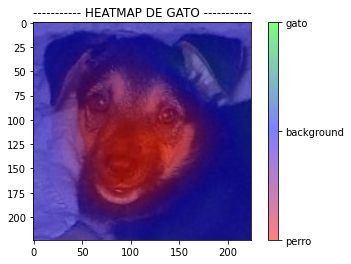

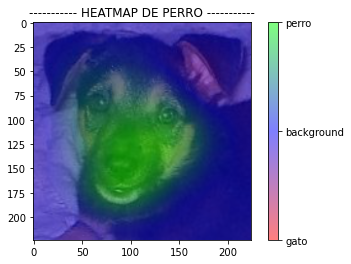

PROB CAM:
	- GATO: 0.00000
	- PERRO: 1.00000
(CLASS PREDICTED -- perro) vs (perro -- ACTUAL CLASS)
######################################################################
######################################################################
######################################################################


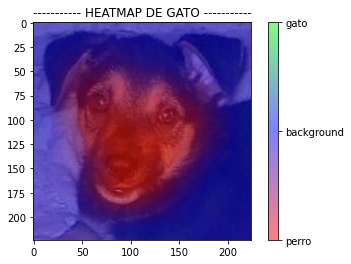

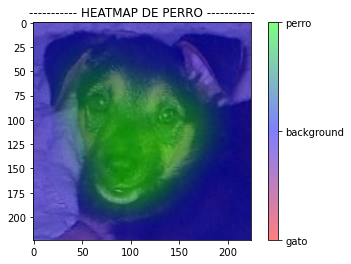

PROB GradCAM:
	- GATO: 0.00000
	- PERRO: 1.00000
(CLASS PREDICTED -- perro) vs (perro -- ACTUAL CLASS)
######################################################################
######################################################################
######################################################################


C:\Users\pedro\AppData\Local\Temp/ipykernel_12592/1043018727.py:112: RuntimeWarning: invalid value encountered in true_divide
  res0 = cv2.resize(heatmaps_new[0]/np.max(np.abs(heatmaps_new[0])), dsize=(224, 224), interpolation=cv2.INTER_CUBIC)


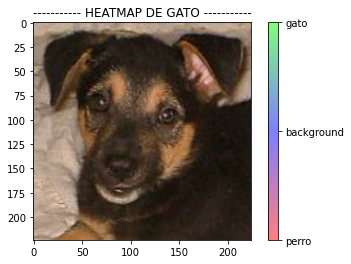

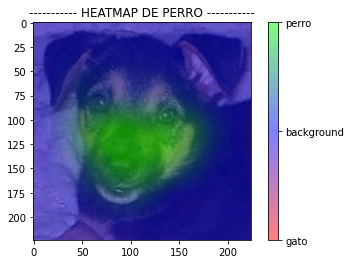

PROB GradCAM++:
	- GATO: 0.00000
	- PERRO: 1.00000
(CLASS PREDICTED -- perro) vs (perro -- ACTUAL CLASS)


In [674]:
# Cogemos la activación de las capas
x, act_classes=next(iter(dataloader_test))
x=x.to(device)

mean = [0.485, 0.456, 0.406]
var = [0.229, 0.224, 0.225]
x_plot=((torch.reshape(x.cpu(), (3,224,224)).permute(1,2,0).numpy())*var)+mean

act_classes=act_classes.to(device)

actual_y = "gato" if act_classes[0]==0 else "perro"
print(actual_y)

model_cam.plot_saliency_map(x, act_classes[0], -2)

print("#"*70)
print("#"*70)
print("#"*70)

model_gradcam.plot_saliency_map(x, act_classes[0], -2)

print("#"*70)
print("#"*70)
print("#"*70)

model_gradcampp.plot_saliency_map(x, act_classes[0], -2)


## PRUEBA GRADIENTES

In [ ]:
t1=torch.tensor(1., requires_grad=True)
t2=torch.tensor(2., requires_grad=True)
t3=torch.tensor(3., requires_grad=True)
################################################

t4 = t1+t2
t5=t4*t3

t5.backward()
print(t3.grad)
################################################

t1.grad=torch.zeros_like(t1)
t2.grad=torch.zeros_like(t2)
t3.grad=torch.zeros_like(t3)

t6= (t3+t1)
t7= t6*t2

t7.backward()
print(t3.grad)

##############################################
prueba = torch.tensor([[[1,1,1],[2,2,2],[3,3,3]], [[4,4,4],[5,5,5],[6,6,6]], [[7,7,7],[8,8,8],[9,9,9]]])

prueba2= torch.sum(prueba,(0))
print(prueba[:,None,None].shape)
print(prueba[:,:,:].shape)
##############################################
input = torch.tensor([[1.,2.],[3.,4.],[5.,6.]], requires_grad=True)
x1 = torch.tensor([[2.,2.],[-0.5,-1.]], requires_grad=True)
x2 = torch.tensor([[0.5],[-1.5]], requires_grad=True)

input.retain_grad()

aux =torch.matmul(input,x1)
y =  torch.exp(torch.matmul(aux,x2))
print(y)

y[0][0].backward(create_graph=True)
print(input.grad)

aux = input.grad[0][0]

input.grad.data.zero_()

aux.backward(create_graph=True)
print(input.grad)
print("="*60)

pesos = torch.tensor([1,2,3,4,5,6,7])
feat = torch.ones((7,2,2))
print(feat[None,:,:,:].shape)
print((feat.T*pesos).T)